<a href="https://colab.research.google.com/github/lallapalooza91/APS360-Final-Project/blob/main/APS360_Project_Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following code defines an LSTM model used to accomplish Twitter Sentiment Analysis.



In [ ]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda")
use_cuda = True

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
# downloading GloVe embeddings
import torchtext
glove_tweet_50 = torchtext.vocab.GloVe(name="twitter.27B", # trained on Wikipedia 2014 corpus
                              dim=50)   # embedding size = 50

glove_tweet_100 = torchtext.vocab.GloVe(name="twitter.27B", # trained on Wikipedia 2014 corpus
                              dim=100)   # embedding size = 100

glove_tweet_200 = torchtext.vocab.GloVe(name="twitter.27B", # trained on Wikipedia 2014 corpus
                              dim=200)   # embedding size = 200
glove_840B = torchtext.vocab.GloVe(name="840B", # trained on Wikipedia 2014 corpus
                              dim=300)   # embedding size = 300

In [ ]:
#setup Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#  code for data processing
# dataset 1
input_file = '/content/drive/My Drive/Tweets.csv'
df = pd.read_csv(input_file)

df = df.drop([df.columns[0],df.columns[2]], axis=1)

# drops null values
if (df.isnull().values.any()):
  df = df.dropna()

# drops duplicated data
if (df.duplicated().sum()):
  df = df.drop_duplicates()

df = df.reset_index(drop = True)

df['sentiment'] = df['sentiment'].astype('category')
idx_to_cat = dict(enumerate(df['sentiment'].cat.categories))
print(idx_to_cat, "\n")
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
print(df)

{0: 'negative', 1: 'neutral', 2: 'positive'} 

                                                    text  sentiment
0                    I`d have responded, if I were going          1
1          Sooo SAD I will miss you here in San Diego!!!          0
2                              my boss is bullying me...          0
3                         what interview! leave me alone          0
4       Sons of ****, why couldn`t they put them on t...          0
...                                                  ...        ...
27475   wish we could come see u on Denver  husband l...          0
27476   I`ve wondered about rake to.  The client has ...          0
27477   Yay good for both of you. Enjoy the break - y...          2
27478                         But it was worth it  ****.          2
27479     All this flirting going on - The ATG smiles...          1

[27480 rows x 2 columns]


In [ ]:
# dataset 2
input_file_2 = '/content/drive/MyDrive/twitter_training.csv'
df2 = pd.read_csv(input_file_2)

df2 = df2.drop([df2.columns[0], df2.columns[1]], axis=1)

df2.columns = ['sentiment', 'text']

cols = df2.columns.tolist()
cols = cols[-1:] + cols[:-1]
df2 = df2[cols]

# drops null values
if (df2.isnull().values.any()):
  df2 = df2.dropna()

# drops duplicated data
if (df2.duplicated().sum()):
  df2 = df2.drop_duplicates()

# drop irrelevant rows
df2.drop(df2[df2['sentiment'] == 'Irrelevant'].index, inplace = True)

df2 = df2.reset_index(drop = True)

df2['sentiment'] = df2['sentiment'].astype('category')
idx_to_cat = dict(enumerate(df2['sentiment'].cat.categories))
print(idx_to_cat, "\n")
cat_columns = df2.select_dtypes(['category']).columns
df2[cat_columns] = df2[cat_columns].apply(lambda x: x.cat.codes)
print(df2)

{0: 'Negative', 1: 'Neutral', 2: 'Positive'} 

                                                    text  sentiment
0      I am coming to the borders and I will kill you...          2
1      im getting on borderlands and i will kill you ...          2
2      im coming on borderlands and i will murder you...          2
3      im getting on borderlands 2 and i will murder ...          2
4      im getting into borderlands and i can murder y...          2
...                                                  ...        ...
57479  Just realized that the Windows partition of my...          2
57480  Just realized that my Mac window partition is ...          2
57481  Just realized the windows partition of my Mac ...          2
57482  Just realized between the windows partition of...          2
57483  Just like the windows partition of my Mac is l...          2

[57484 rows x 2 columns]


<ipython-input-7-0afe6587dc4f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(df2[df2['sentiment'] == 'Irrelevant'].index, inplace = True)


In [ ]:
# dataset 3
input_file3 = '/content/drive/MyDrive/BTC_tweets_daily_example.csv'
df3 = pd.read_csv(input_file3)

df3 = df3.drop([df3.columns[0], df3.columns[1], df3.columns[3], df3.columns[4], df3.columns[5], df3.columns[7], df3.columns[8], df3.columns[9]], axis=1)

df3.columns = ['text', 'sentiment']

# drops null values
if (df3.isnull().values.any()):
  df3 = df3.dropna()

# drops duplicated data
if (df3.duplicated().sum()):
  df3 = df3.drop_duplicates()

df3 = df3.reset_index(drop = True)

# drop irrelevant rows
df3.drop(df3[df3['sentiment'] == '0.0'].index, inplace = True)

df3['sentiment'] = df3['sentiment'].astype('category')
idx_to_cat = dict(enumerate(df3['sentiment'].cat.categories))
print(idx_to_cat, "\n")
cat_columns = df3.select_dtypes(['category']).columns
df3[cat_columns] = df3[cat_columns].apply(lambda x: x.cat.codes)

print(df3)

{0: "['negative']", 1: "['neutral']", 2: "['positive']"} 

                                                    text  sentiment
0      RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...          1
1      @lopp @_Kevin_Pham @psycho_sage @naval But @Pr...          1
2      RT @tippereconomy: Another use case for #block...          2
3                     free coins https://t.co/DiuoePJdap          2
4      RT @payvxofficial: WE are happy to announce th...          2
...                                                  ...        ...
28131  #Zhao #Dong #Recounts How He Lost 9,000 #BTC h...          1
28132  RT @LisaLisaTokyo: Maaan, BiTCh is a bitch,\nI...          2
28133  Bitcoin Price Technical Analysis for 03/23/201...          1
28134  I added a video to a @YouTube playlist https:/...          2
28135  RT @Raybambs: Airdrop PhotoCoin Airdrop Round#...          2

[28135 rows x 2 columns]


In [ ]:
# dataset 4
input_file4 = '/content/drive/MyDrive/train.csv'
df4 = pd.read_csv(input_file4, encoding = 'iso-8859-1')

df4 = df4.drop([df4.columns[0],df4.columns[2],
                df4.columns[4],df4.columns[5],
                df4.columns[6],df4.columns[7],
                df4.columns[8],df4.columns[9]],
                axis=1)


df4.columns = ['text', 'sentiment']


# drops null values
if (df4.isnull().values.any()):
  df4 = df4.dropna()

# drops duplicated data
if (df4.duplicated().sum()):
  df4 = df4.drop_duplicates()

df4 = df4.reset_index(drop = True)

# drop irrelevant rows
df4.drop(df4[df4['sentiment'] == '0.0'].index, inplace = True)

df4['sentiment'] = df4['sentiment'].astype('category')
idx_to_cat = dict(enumerate(df4['sentiment'].cat.categories))
print(idx_to_cat, "\n")

cat_columns = df4.select_dtypes(['category']).columns
df4[cat_columns] = df4[cat_columns].apply(lambda x: x.cat.codes)

print(df4)

{0: 'negative', 1: 'neutral', 2: 'positive'} 

                                                    text  sentiment
0                    I`d have responded, if I were going          1
1          Sooo SAD I will miss you here in San Diego!!!          0
2                              my boss is bullying me...          0
3                         what interview! leave me alone          0
4       Sons of ****, why couldn`t they put them on t...          0
...                                                  ...        ...
27475   wish we could come see u on Denver  husband l...          0
27476   I`ve wondered about rake to.  The client has ...          0
27477   Yay good for both of you. Enjoy the break - y...          2
27478                         But it was worth it  ****.          2
27479     All this flirting going on - The ATG smiles...          1

[27480 rows x 2 columns]


In [ ]:
# dataset 5
input_file5 = '/content/drive/MyDrive/test.csv'
df5 = pd.read_csv(input_file5, encoding = 'iso-8859-1')

df5 = df5.drop([df5.columns[0],df5.columns[3],
                df5.columns[4],df5.columns[5],
                df5.columns[6],df5.columns[7],
                df5.columns[8]],
                axis=1)


df5.columns = ['text', 'sentiment']


# drops null values
if (df5.isnull().values.any()):
  df5 = df5.dropna()

# drops duplicated data
if (df5.duplicated().sum()):
  df5 = df5.drop_duplicates()

df5 = df5.reset_index(drop = True)

# drop irrelevant rows
df5.drop(df5[df5['sentiment'] == '0.0'].index, inplace = True)

df5['sentiment'] = df5['sentiment'].astype('category')
idx_to_cat = dict(enumerate(df5['sentiment'].cat.categories))
print(idx_to_cat, "\n")

cat_columns = df5.select_dtypes(['category']).columns
df5[cat_columns] = df5[cat_columns].apply(lambda x: x.cat.codes)

print(df5)

{0: 'negative', 1: 'neutral', 2: 'positive'} 

                                                   text  sentiment
0     Last session of the day  http://twitpic.com/67ezh          1
1      Shanghai is also really exciting (precisely -...          2
2     Recession hit Veronique Branquinho, she has to...          0
3                                           happy bday!          2
4                http://twitpic.com/4w75p - I like it!!          2
...                                                 ...        ...
3529  its at 3 am, im very tired but i can`t sleep  ...          0
3530  All alone in this old house again.  Thanks for...          2
3531   I know what you mean. My little dog is sinkin...          0
3532  _sutra what is your next youtube video gonna b...          2
3533   http://twitpic.com/4woj2 - omgssh  ang cute n...          2

[3534 rows x 2 columns]


In [ ]:
df_final = pd.concat([df,df2,df3,df4,df5])
df_final = df_final.sample(frac=1)

print(df_final)

training_split = int(len(df_final)*0.70)
validation_split = int(len(df_final)*0.85)

train_df = df_final[:training_split]
val_df = df_final[training_split:validation_split]
test_df = df_final[validation_split:]

print(len(train_df))
print(len(val_df))
print(len(test_df))

                                                    text  sentiment
609    @TalkingHat @stefapie all your Bitcoin are bel...          1
9195              learn learn!... we can learn together!          2
7680   Long/Short Bitcoin swings with up to 100x Leve...          1
30636  Favorite Personal Singleplayer: FO New Vegas. ...          0
14524            OO YAY 39 FOLLOWERS I WANT 100  HELP ME          2
...                                                  ...        ...
35538  @ GovRonDeSantis I've been to Walmart once thi...          0
4888      http://twitpic.com/4i2zu - wow, thats so cool!          2
8287            13:00 is kickoff. The red cars hopefully          2
43471                                 Dont come to mind.          1
18563   - I enjoyed seeing EVERYONE that presented on...          2

[144113 rows x 2 columns]
100879
21617
21617


In [ ]:
# helper function to obtain glove embeddings
def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

In [ ]:
# helper function to obtain glove embeddings
def glove_vectorize_data(train_df,val_df,test_df, glove_embedding):
  train_data = []
  val_data = []
  test_data = []

  for i in range(len(train_df['text'])):
      tweet = train_df['text'].iloc[i]
      idxs = [glove_embedding.stoi[w]        # lookup the index of word and storing the indices in a tensor
              for w in split_tweet(tweet)
              if w in glove_embedding.stoi] # keep words that has an embedding
      if not idxs: # ignore tweets without any word with an embedding
        continue
      idxs = torch.tensor(idxs) # convert list to pytorch tensor
      label = torch.tensor(int(train_df['sentiment'].iloc[i]))
      train_data.append((idxs, label))

  for i in range(len(val_df['text'])):
      tweet = val_df['text'].iloc[i]
      idxs = [glove_embedding.stoi[w]        # lookup the index of word and storing the indices in a tensor
              for w in split_tweet(tweet)
              if w in glove_embedding.stoi] # keep words that has an embedding
      if not idxs: # ignore tweets without any word with an embedding
        continue
      idxs = torch.tensor(idxs) # convert list to pytorch tensor
      label = torch.tensor(int(val_df['sentiment'].iloc[i]))
      val_data.append((idxs, label))

  for i in range(len(test_df['text'])):
      tweet = test_df['text'].iloc[i]
      idxs = [glove_embedding.stoi[w]        # lookup the index of word and storing the indices in a tensor
              for w in split_tweet(tweet)
              if w in glove_embedding.stoi] # keep words that has an embedding
      if not idxs: # ignore tweets without any word with an embedding
        continue
      idxs = torch.tensor(idxs) # convert list to pytorch tensor
      label = torch.tensor(int(test_df['sentiment'].iloc[i]))
      test_data.append((idxs, label))

  return train_data, val_data, test_data

In [ ]:
# getting glove embeddings for data
train_data_50, val_data_50, test_data_50 = glove_vectorize_data(train_df,val_df,test_df, glove_tweet_50)
train_data_100, val_data_100, test_data_100 = glove_vectorize_data(train_df,val_df,test_df, glove_tweet_100)
train_data_200, val_data_200, test_data_200 = glove_vectorize_data(train_df,val_df,test_df, glove_tweet_200)
train_data_840, val_data_840, test_data_840 = glove_vectorize_data(train_df,val_df,test_df, glove_840B)

In [ ]:
# helper function for batching tweets into groups of the same length
import random

class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)

        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}

    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [ ]:
#load data for models
#batch_size = 32
train_loader_32_50 = TweetBatcher(train_data_50, batch_size=32, drop_last=False)
valid_loader_32_50 = TweetBatcher(val_data_50, batch_size=32, drop_last=False)
test_loader_32_50 = TweetBatcher(test_data_50, batch_size=32, drop_last=False)
train_loader_32_100 = TweetBatcher(train_data_100, batch_size=32, drop_last=False)
valid_loader_32_100 = TweetBatcher(val_data_100, batch_size=32, drop_last=False)
test_loader_32_100 = TweetBatcher(test_data_100, batch_size=32, drop_last=False)
train_loader_32_200 = TweetBatcher(train_data_200, batch_size=32, drop_last=False)
valid_loader_32_200 = TweetBatcher(val_data_200, batch_size=32, drop_last=False)
test_loader_32_200 = TweetBatcher(test_data_200, batch_size=32, drop_last=False)
train_loader_32_840 = TweetBatcher(train_data_840, batch_size=32, drop_last=False)
valid_loader_32_840 = TweetBatcher(val_data_840, batch_size=32, drop_last=False)
test_loader_32_840 = TweetBatcher(test_data_840, batch_size=32, drop_last=False)
#batch_size = 64
train_loader_64_50 = TweetBatcher(train_data_50, batch_size=64, drop_last=False)
valid_loader_64_50 = TweetBatcher(val_data_50, batch_size=64, drop_last=False)
test_loader_64_50 = TweetBatcher(test_data_50, batch_size=64, drop_last=False)
train_loader_64_100 = TweetBatcher(train_data_100, batch_size=64, drop_last=False)
valid_loader_64_100 = TweetBatcher(val_data_100, batch_size=64, drop_last=False)
test_loader_64_100 = TweetBatcher(test_data_100, batch_size=64, drop_last=False)
train_loader_64_200 = TweetBatcher(train_data_200, batch_size=64, drop_last=False)
valid_loader_64_200 = TweetBatcher(val_data_200, batch_size=64, drop_last=False)
test_loader_64_200 = TweetBatcher(test_data_200, batch_size=64, drop_last=False)
train_loader_64_840 = TweetBatcher(train_data_840, batch_size=64, drop_last=False)
valid_loader_64_840 = TweetBatcher(val_data_840, batch_size=64, drop_last=False)
test_loader_64_840 = TweetBatcher(test_data_840, batch_size=64, drop_last=False)
#batch size = 128
train_loader_128_840 = TweetBatcher(train_data_840, batch_size=128, drop_last=False)
valid_loader_128_840 = TweetBatcher(val_data_840, batch_size=128, drop_last=False)
test_loader_128_840 = TweetBatcher(test_data_840, batch_size=128, drop_last=False)
#batch size = 256
train_loader_256_840 = TweetBatcher(train_data_840, batch_size=256, drop_last=False)
valid_loader_256_840 = TweetBatcher(val_data_840, batch_size=256, drop_last=False)
test_loader_256_840 = TweetBatcher(test_data_840, batch_size=256, drop_last=False)

In [ ]:
#  helper function to calculate accuracy of the model
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          tweets = tweets.cuda()
          labels = labels.cuda()
        #############################################
        # print('Tweets: {}'.format(tweets))
        # print('Labels: {}'.format(labels))

        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

In [ ]:
# helper function used to save checkpoints
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
# training code
def train_rnn_network(model, train, valid, num_epochs=5, batch_size = 64, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses, train_acc, valid_acc = [], [], [], []
    epochs = []

    for epoch in range(num_epochs):
        for tweets, labels in train:
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              tweets = tweets.cuda()
              labels = labels.cuda()
            #############################################

            optimizer.zero_grad()
            pred = model(tweets)
            train_loss = criterion(pred, labels)
            train_loss.backward()
            optimizer.step()

        for tweets, labels in valid:
          #############################################
          #To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
            tweets = tweets.cuda()
            labels = labels.cuda()
          #############################################

          optimizer.zero_grad()
          pred = model(tweets)
          val_loss = criterion(pred, labels)

        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))

        print("Epoch {}; Train Loss {}; Train Acc {}; Val Loss {}; Val Acc {}".format(
              epoch+1, train_losses[-1], train_acc[-1], val_losses[-1], valid_acc[-1]))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
# our final model: 2 layer LSTM
class TweetLSTM_concat_dropout2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout, glove_embedding):
        super(TweetLSTM_concat_dropout2, self).__init__()
        self.name = 'lstm_concat_dropout2'+'_'+str(input_size)+'_'+str(hidden_size)+'_'+str(dropout)
        self.emb = nn.Embedding.from_pretrained(glove_embedding.vectors)
        self.hidden_size = hidden_size
        self.rnn1 = nn.LSTM(input_size, hidden_size, dropout=dropout, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.rnn2 = nn.LSTM(hidden_size, hidden_size, dropout=dropout, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*2, num_classes)


    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the LSTM
        out, _ = self.rnn1(x, (h0, c0))
        out = self.dropout1(out)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the LSTM
        out, _ = self.rnn2(out, (h0, c0))
        out = self.dropout2(out)
        # Pass the output of the last time step to the classifier
        out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)


        return out


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1; Train Loss 0.821543276309967; Train Acc 0.6291191318519697; Val Loss 0.602875828742981; Val Acc 0.6262223664086759
Epoch 2; Train Loss 0.5489426851272583; Train Acc 0.6528898517311286; Val Loss 0.854331374168396; Val Acc 0.6509245956342402
Epoch 3; Train Loss 0.6684116125106812; Train Acc 0.6713737727073975; Val Loss 0.9411542415618896; Val Acc 0.6681188302358994
Epoch 4; Train Loss 0.6821420788764954; Train Acc 0.6825237508446953; Val Loss 0.33134931325912476; Val Acc 0.6769708485887751
Epoch 5; Train Loss 0.6163443922996521; Train Acc 0.6851075247446039; Val Loss 0.7211886048316956; Val Acc 0.6784539092552254
Epoch 6; Train Loss 0.65876305103302; Train Acc 0.7006002305521326; Val Loss 0.9189262986183167; Val Acc 0.6919868378365852
Epoch 7; Train Loss 0.6821126937866211; Train Acc 0.7110943276225306; Val Loss 0.7024368643760681; Val Acc 0.698985030356398
Epoch 8; Train Loss 0.5461985468864441; Train Acc 0.717116508327702; Val Loss 1.0967801809310913; Val Acc 0.704917273022199

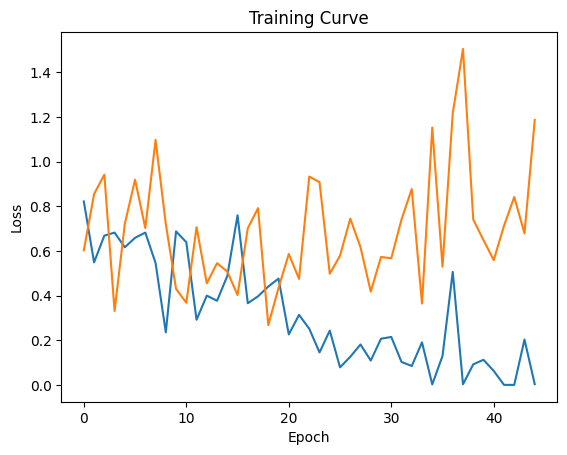

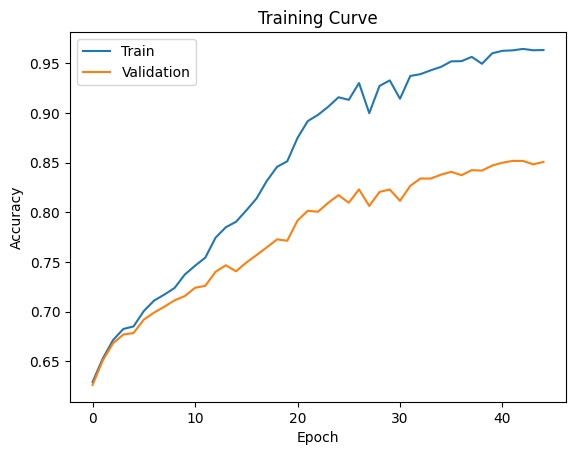

In [ ]:
# final training curve
model12 = TweetLSTM_concat_dropout2(300,600,3,0.9,glove_840B)
model12.cuda()
train_rnn_network(model12, train_loader_128_840, valid_loader_128_840, num_epochs = 45, batch_size = 128, learning_rate = 5e-4)

In [ ]:
# freezing the best model
model_path = get_model_name('lstm_concat_dropout2_300_600_0.9', batch_size=128, learning_rate=5e-4, epoch=42)
state = torch.load(model_path)
bestModel= TweetLSTM_concat_dropout2(300, 600, 3, 0.9, glove_840B)
bestModel.cuda()
bestModel.load_state_dict(state)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [ ]:
# saving best model to Drive
save_path = '/content/drive/MyDrive/checkpoints/bestModel'
torch.save(state, save_path)

In [ ]:
# loading saved model
drive_path = '/content/drive/MyDrive/Copy of bestmodelFixed.pt'
new_model = TweetLSTM_concat_dropout2(300, 600, 3, 0.9, glove_840B)
new_model.cuda()
new_model.load_state_dict(torch.load(drive_path))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [ ]:
# finding training and validation accuracy of best model
use_cuda = True
print('Valid accuracy of best model so far is: {} %'.format(get_accuracy(bestModel, valid_loader_128_840)*100))
print('Train accuracy of best model so far is: {} %'.format(get_accuracy(bestModel, train_loader_128_840)*100))

Valid accuracy of best model so far is: 86.15192102701951 %
Train accuracy of best model so far is: 97.3118813849028 %


In [ ]:
# finding test accuracy of best model
print('Test accuracy of best model so far is: {} %'.format(get_accuracy(bestModel, test_loader_128_840)*100))

Test accuracy of best model so far is: 85.84608252202133 %


Accuracy: 0.86%, 
    Precision: [87.10898913 83.06275187 89.23437958], 
    Recall: [85.43516874 88.11530475 84.53522301], 
    F1-score: [86.26396022 85.51446183 86.82126293]
    Confusion matrix:
 [[5291  652  250]
 [ 489 7214  484]
 [ 294  819 6084]]


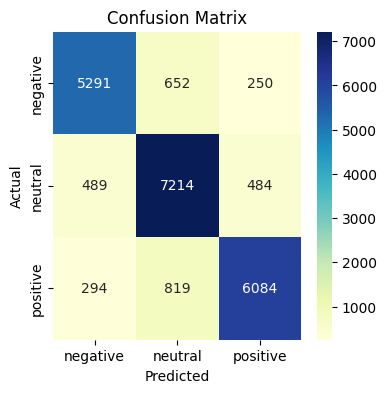

In [ ]:
# evaluating precision, recall, f1-score and confusion matrix for best model
# on validation data
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(model, dataloader):
    """Evaluates the model on the given dataset and calculates precision, recall, and F1-score for each class."""
    model.eval()
    true_labels = torch.tensor([], dtype=torch.long)
    predicted_labels = torch.tensor([], dtype=torch.long)
    true_labels = true_labels.cuda()
    predicted_labels = predicted_labels.cuda()
    with torch.no_grad():
        for tweets, labels in dataloader:
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                tweets = tweets.cuda()
                labels = labels.cuda()
            #############################################
            outputs = model(tweets)
            predicted = torch.argmax(outputs, dim=1)
            true_labels = torch.cat((true_labels, labels), dim=0)
            predicted_labels = torch.cat((predicted_labels, predicted), dim=0)

    accuracy = (true_labels == predicted_labels).sum().item() / len(true_labels)

    cm = confusion_matrix(true_labels.cpu().numpy(), predicted_labels.cpu().numpy())
    precision = 100 * cm.diagonal() / cm.sum(axis=0)
    recall = 100 * cm.diagonal() / cm.sum(axis=1)
    f1_score = 2 * precision * recall / (precision + recall)

    print(f'''Accuracy: {accuracy:.2f}%,
    Precision: {precision},
    Recall: {recall},
    F1-score: {f1_score}
    Confusion matrix:\n {cm}''')
    class_names = ['negative', 'neutral', 'positive']
    # Plot the confusion matrix as a heatmap
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

evaluate(bestModel, valid_loader_128_840)

Accuracy: 0.86%, 
    Precision: [87.65120968 81.87314625 89.36077058], 
    Recall: [83.48535766 88.82425743 84.56014363], 
    F1-score: [85.51758053 85.20717084 86.8942028 ]
    Confusion matrix:
 [[5217  784  248]
 [ 422 7177  481]
 [ 313  805 6123]]


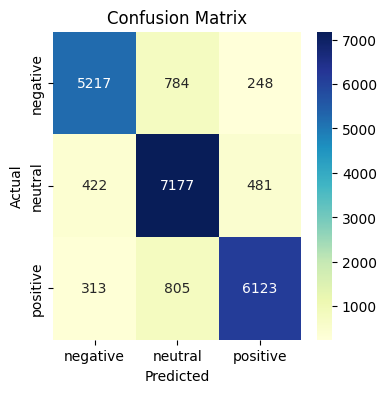

In [ ]:
# evaluating precision, recall, f1-score and confusion matrix for best model
# on testing data
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(model, dataloader):
    """Evaluates the model on the given dataset and calculates precision, recall, and F1-score for each class."""
    model.eval()
    true_labels = torch.tensor([], dtype=torch.long)
    predicted_labels = torch.tensor([], dtype=torch.long)
    true_labels = true_labels.cuda()
    predicted_labels = predicted_labels.cuda()
    with torch.no_grad():
        for tweets, labels in dataloader:
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                tweets = tweets.cuda()
                labels = labels.cuda()
            #############################################
            outputs = model(tweets)
            predicted = torch.argmax(outputs, dim=1)
            true_labels = torch.cat((true_labels, labels), dim=0)
            predicted_labels = torch.cat((predicted_labels, predicted), dim=0)

    accuracy = (true_labels == predicted_labels).sum().item() / len(true_labels)

    cm = confusion_matrix(true_labels.cpu().numpy(), predicted_labels.cpu().numpy())
    precision = 100 * cm.diagonal() / cm.sum(axis=0)
    recall = 100 * cm.diagonal() / cm.sum(axis=1)
    f1_score = 2 * precision * recall / (precision + recall)

    print(f'''Accuracy: {accuracy:.2f}%,
    Precision: {precision},
    Recall: {recall},
    F1-score: {f1_score}
    Confusion matrix:\n {cm}''')
    class_names = ['negative', 'neutral', 'positive']
    # Plot the confusion matrix as a heatmap
    fig, ax = plt.subplots(figsize=(4,4 ))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

evaluate(bestModel, test_loader_128_840)

In [ ]:
# helper function to obtain results for demonstration and qualtiative results
def get_new_tweet(glove_vector, sample_tweet):
    tweet = sample_tweet
    idxs = [glove_vector.stoi[w]        # lookup the index of word
            for w in split_tweet(tweet)
            if w in glove_vector.stoi] # keep words that has an embedding
    idxs = torch.tensor(idxs) # convert list to pytorch tensor
    return idxs

In [ ]:
# dictionary for sentiment values
sentiments = {0: 'negative', 1: 'neutral', 2: 'positive'}

In [ ]:
# code used to obtain
# qualitative result from presentation - shows random samples from test data
import random
import textwrap

i=0
print("Testing model on random samples from test data:\n")

#time.sleep(10)
# Assuming your test data is in a DataLoader called `test_loader`
for batch_idx, (inputs, targets) in enumerate(valid_loader_128_840):
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      inputs = inputs.cuda()
      targets = targets.cuda()
    #############################################
    # Get a random sample index within the batch
    sample_idx = random.randint(0, len(inputs) - 1)
    # Get the input and target for the selected sample
    input_sample = inputs[sample_idx]
    target_sample = targets[sample_idx]
    # Make a prediction for the input sample
    output = new_model(input_sample.unsqueeze(0))
    _, pred = output.max(1)
    pred_label = pred.item()
    # Convert tensor to list of word indices
    word_indices = input_sample.cpu().numpy().tolist()

    # Lookup words in the GloVe embeddings dictionary
    words = [glove_840B.itos[idx] for idx in word_indices]

    # Concatenate words to form original tweet text
    text = ' '.join(words)

    # Wrap the text to a width of 170
    text_wrapped = textwrap.fill(text, width=150)


    # Print the input sample and predicted label
    print('Example {}:'.format(batch_idx * 128 + sample_idx))
    print('Input: {}'.format(text_wrapped))
    #time.sleep(1)
    print('Predicted label: {}'.format(sentiments[pred_label]))
    print('True label: {}'.format(sentiments[target_sample.item()]))
    print('\n')
    #time.sleep(1.5)
    i+=1
    if i>10:
      break


In [ ]:
# code used for demonstration in final presentation
# look at model's performance on Elon Musk's recent tweets
my_list = ['NPR literally said “Federal funding is essential to public radio” on their own website (now taken down).What hypocrites!',
          'I said BBC could come Twitter, then, to my surprise, a reporter shows up',
           'We need a VP of Propaganda … errr I mean Public Relations!',
           'An advantage of having organizational affiliation on this platform is that you can change your name without losing verification. More importantly, it helps greatly with reducing impersonation fraud.'
           'Tbh, I’m just hoping a media org that takes itself way too seriously writes a story about Harry Bōlz …',
           'On the Internet, I’m only 3 inches tall (best case)',
           'Impersonating others is wrong!',
           'Starship launch trending towards near the end of third week of April',
           'Friendship takes work, enmity is effortless',
          'I wish the media would stop flattering me all time … it’s a bit much guys',
          'They should really get rid of that 100 IQ maximum limit for creating an account on Instagram',
          'Credit to Tim Sweeney for realizing this before me',
          'Great interview on AI',
          'Feels like the future',
          'Walked whole Cybertruck production line at Giga Texas for several hours earlier today – gonna be awesome!',
          "The real tragedy of @NYTimes is that their propaganda isn't even interesting",
          'Also, their feed is the Twitter equivalent of diarrhea. It’s unreadable. They would have far more real followers if they only posted their top articles. Same applies to all publications.',
          'Don’t Look Up … but AGI instead of comet',
          'We live in the most interesting of times',
          'Twitter will be updating its recommendation algorithm based on user suggestions every 24 to 48 hours',
           'I hate lying to my parents but it’s for their own good',
           'She FINALLY texted me after 17 hours now I will make her wait 22 seconds',
           'It’s me and my 3 hours of sleep against the world']

# Set the width of the text to wrap to
width = 170

print("Testing our model on Elon Musk's recent tweets...\n")
#time.sleep(1)

# Loop through the list and wrap each string
for string in my_list:
    wrapped_text = textwrap.fill(string, width=width)
    new_tweet = get_new_tweet(glove_840B, wrapped_text).cuda()
    out = torch.sigmoid(new_model(new_tweet.unsqueeze(0)))
    pred = out.max(1, keepdim=True)[1]
    print("Tweet: {}".format(wrapped_text))
    #time.sleep(1)
    print("Sentiment: {}\n".format(sentiments[pred.item()]))
    #time.sleep(1)


Testing our model on Elon Musk's recent tweets...

Tweet: NPR literally said “Federal funding is essential to public radio” on their own website (now taken down).What hypocrites!
Sentiment: positive

Tweet: I said BBC could come Twitter, then, to my surprise, a reporter shows up
Sentiment: neutral

Tweet: We need a VP of Propaganda … errr I mean Public Relations!
Sentiment: negative

Tweet: An advantage of having organizational affiliation on this platform is that you can change your name without losing verification. More importantly, it helps greatly with
reducing impersonation fraud.Tbh, I’m just hoping a media org that takes itself way too seriously writes a story about Harry Bōlz …
Sentiment: positive

Tweet: On the Internet, I’m only 3 inches tall (best case)
Sentiment: neutral

Tweet: Impersonating others is wrong!
Sentiment: neutral

Tweet: Starship launch trending towards near the end of third week of April
Sentiment: positive

Tweet: Friendship takes work, enmity is effortless

In [ ]:
# code used to obtain qualitative result for final report

import random
import textwrap

i=0
print("Testing model on validation data:\n")

# Assuming your validation data is in a DataLoader called `valid_loader_128_840`
for batch_idx, (inputs, targets) in enumerate(train_loader_128_840):
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      inputs = inputs.cuda()
      targets = targets.cuda()
    #############################################
    # Loop through all samples in the batch
    for sample_idx in range(len(inputs)):
        # Get the input and target for the selected sample
        input_sample = inputs[sample_idx]
        target_sample = targets[sample_idx]
        # Make a prediction for the input sample
        output = new_model(input_sample.unsqueeze(0))
        _, pred = output.max(1)
        pred_label = pred.item()
        # Convert tensor to list of word indices
        word_indices = input_sample.cpu().numpy().tolist()

        # Lookup words in the GloVe embeddings dictionary
        words = [glove_840B.itos[idx] for idx in word_indices]

        # Concatenate words to form original tweet text
        text = ' '.join(words)

        # Wrap the text to a width of 150
        text_wrapped = textwrap.fill(text, width=100)

        # showing specific results of our model
        if sentiments[pred_label] == 'positive' and sentiments[target_sample.item()] == 'positive':
          # Print the input sample and predicted label
          print('Example {}:'.format(batch_idx * len(inputs) + sample_idx))
          print('Input: {}'.format(text_wrapped))
          print('Predicted label: {}'.format(sentiments[pred_label]))
          print('True label: {}'.format(sentiments[target_sample.item()]))
          print('\n')

        i += 1
        if i > 10000000:
          break

    if i > 10000000:
      break
